#### Integration of human fetal stem cells and mouse stem cells with `scVI` and `scANVI` pipeline
- **Developed by:** Anna Maguza
- **Affilation:** Faculty of Medicine, Würzburg University
- **Date of creation:** 4th September 2024
- **Last modified date:** 4th September 2024

This notebook is created to integrate human gut fetal stem cells from Elementaite, 2021 dataset and mouse gut stem cells from Haber, 2017 study using `scVI` and `scANVI` tools, and then measure the quality of integration with `scIB` metrics. The orthologues were taken from `ensemble` database. 

##### Import packages

In [44]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

##### Setup working environment

In [45]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [46]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [47]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [48]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

#### Read in data

In [49]:
human_adata = sc.read_h5ad("data/Fetal_stem_cells_leiden.h5ad")

In [50]:
mouse_adata = sc.read_h5ad("data/Haber_2017_Smartseq_stem_cells_remapped.h5ad")

#### Create common set of genes

In [51]:
orthologues = pd.read_csv("database_data/ensembl_data/mouse_to_human_orthologues_ensembl.txt", sep = "\t")

In [52]:
mouse_adata.var

,ensemble_gene_id_version,ensemble_gene_id,start_position,end_position,chromosome_name,external_gene_name,n_counts,n_cells
external_gene_name,,,,,,,,
Xkr4,ENSMUSG00000051951.6,ENSMUSG00000051951,3276124,3741721,1,Xkr4,64.0,4
Gm37180,ENSMUSG00000103377.2,ENSMUSG00000103377,3435954,3438772,1,Gm37180,63.0,3
Gm37363,ENSMUSG00000104017.2,ENSMUSG00000104017,3445779,3448011,1,Gm37363,364.0,3
Gm37686,ENSMUSG00000103025.2,ENSMUSG00000103025,3535200,3537508,1,Gm37686,49.0,4
Rp1,ENSMUSG00000025900.14,ENSMUSG00000025900,4069780,4479464,1,Rp1,307.0,15
...,...,...,...,...,...,...,...,...
mt-Tt,ENSMUSG00000064371.1,ENSMUSG00000064371,15289,15355,MT,mt-Tt,2386.0,373
mt-Tp,ENSMUSG00000064372.1,ENSMUSG00000064372,15356,15422,MT,mt-Tp,7391.0,462
nan,ENSMUSG00000079808.4,ENSMUSG00000079808,128555,150452,GL456212.1,nan,24.0,8


In [53]:
mouse_adata.var['ensemble_gene_id_version'].duplicated().sum()

0

In [54]:
orthologues['Gene stable ID version'].duplicated().sum()

85346

In [55]:
orthologues

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Human gene stable ID,Human gene name,Human homology type,%id. target Human gene identical to query gene,%id. query gene identical to target Human gene,Human Gene-order conservation score,"Human orthology confidence [0 low, 1 high]",Human protein or transcript stable ID,Query protein or transcript ID,Protein stable ID,Protein stable ID version,Gene name
0,ENSMUSG00000064341,ENSMUSG00000064341.1,ENSMUST00000082392,ENSMUST00000082392.1,ENSG00000198888,MT-ND1,ortholog_one2one,77.0440,77.0440,50.0,1,ENSP00000354687,ENSMUSP00000080991,ENSMUSP00000080991,ENSMUSP00000080991.1,mt-Nd1
1,ENSMUSG00000064345,ENSMUSG00000064345.1,ENSMUST00000082396,ENSMUST00000082396.1,ENSG00000198763,MT-ND2,ortholog_one2one,57.3913,57.0605,75.0,1,ENSP00000355046,ENSMUSP00000080992,ENSMUSP00000080992,ENSMUSP00000080992.1,mt-Nd2
2,ENSMUSG00000064351,ENSMUSG00000064351.1,ENSMUST00000082402,ENSMUST00000082402.1,ENSG00000198804,MT-CO1,ortholog_one2one,90.6615,90.8382,100.0,1,ENSP00000354499,ENSMUSP00000080993,ENSMUSP00000080993,ENSMUSP00000080993.1,mt-Co1
3,ENSMUSG00000064354,ENSMUSG00000064354.1,ENSMUST00000082405,ENSMUST00000082405.1,ENSG00000198712,MT-CO2,ortholog_one2one,71.3656,71.3656,100.0,1,ENSP00000354876,ENSMUSP00000080994,ENSMUSP00000080994,ENSMUSP00000080994.1,mt-Co2
4,ENSMUSG00000064356,ENSMUSG00000064356.1,ENSMUST00000082407,ENSMUST00000082407.1,ENSG00000228253,MT-ATP8,ortholog_one2one,46.2687,45.5882,100.0,0,ENSP00000355265,ENSMUSP00000080995,ENSMUSP00000080995,ENSMUSP00000080995.1,mt-Atp8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105814,ENSMUSG00000038400,ENSMUSG00000038400.17,ENSMUST00000249934,ENSMUST00000249934.1,ENSG00000124225,PMEPA1,ortholog_one2one,80.1282,87.1080,100.0,1,ENSP00000345826,ENSMUSP00000115534,ENSMUSP00000160031,ENSMUSP00000160031.1,Pmepa1
105815,ENSMUSG00000038400,ENSMUSG00000038400.17,ENSMUST00000124124,ENSMUST00000124124.2,ENSG00000124225,PMEPA1,ortholog_one2one,80.1282,87.1080,100.0,1,ENSP00000345826,ENSMUSP00000115534,NaN,NaN,Pmepa1
105816,ENSMUSG00000025314,ENSMUSG00000025314.19,ENSMUST00000129323,ENSMUST00000129323.2,ENSG00000149177,PTPRJ,ortholog_one2one,63.8519,64.4727,100.0,1,ENSP00000400010,ENSMUSP00000129592,NaN,NaN,Ptprj
105817,ENSMUSG00000025314,ENSMUSG00000025314.19,ENSMUST00000111495,ENSMUST00000111495.9,ENSG00000149177,PTPRJ,ortholog_one2one,63.8519,64.4727,100.0,1,ENSP00000400010,ENSMUSP00000129592,ENSMUSP00000107121,ENSMUSP00000107121.3,Ptprj


In [56]:
orthologues = orthologues.sort_values("%id. target Human gene identical to query gene", ascending = False).drop_duplicates("Gene stable ID version", keep = "first")

In [57]:
mouse_adata.var = mouse_adata.var.merge(orthologues, left_on = 'ensemble_gene_id_version', right_on = 'Gene stable ID version', how = 'left')

In [58]:
mouse_adata.var.index = mouse_adata.var['Gene name']

In [63]:
var_df = mouse_adata.var.copy()
var_df = var_df.sort_values("%id. target Human gene identical to query gene", ascending=False)
keep_genes = pd.Series(True, index=var_df.index)
keep_genes[var_df["Gene name"].duplicated(keep="first")] = False
mouse_adata = mouse_adata[:, keep_genes].copy()
mouse_adata.var = var_df.loc[keep_genes]

Shape of mouse_adata after processing: (489, 14803)
Number of entries in var: 14803
Number of var_names: 14803
Number of remaining duplicates: 0


In [64]:
mouse_adata

AnnData object with n_obs × n_vars = 489 × 14803
    obs: 'barcode', 'Gene_marker', 'Donor_ID', 'GFP_intensity', 'full_cell_description', 'cell_type', 'Sample', 'n_genes', 'n_counts'
    var: 'ensemble_gene_id_version', 'ensemble_gene_id', 'start_position', 'end_position', 'chromosome_name', 'external_gene_name', 'n_counts', 'n_cells', 'Gene stable ID', 'Gene stable ID version', 'Transcript stable ID', 'Transcript stable ID version', 'Human gene stable ID', 'Human gene name', 'Human homology type', '%id. target Human gene identical to query gene', '%id. query gene identical to target Human gene', 'Human Gene-order conservation score', 'Human orthology confidence [0 low, 1 high]', 'Human protein or transcript stable ID', 'Query protein or transcript ID', 'Protein stable ID', 'Protein stable ID version', 'Gene name'

+ Prepare obs

In [65]:
mouse_adata.obs['Library_Preparation_Protocol'] = 'Smart-seq2'
mouse_adata.obs['Sample_ID'] = mouse_adata.obs['Sample']
mouse_adata.obs['Study_name'] = 'Haber, 2017'


+ Concatenate datasets

In [66]:
adata = human_adata.concatenate(mouse_adata, batch_key = 'dataset', batch_categories = ['human', 'mouse'], join='inner', index_unique = None)

+ Run PCA

In [67]:
sc.pp.pca(adata)

computing PCA
    with n_comps=10
    finished (0:00:00)


In [68]:
adata.obs

,Sample_ID,Cell Type,Study_name,Donor_ID,Diagnosis,Age,Region code,Fraction,Sex,Library_Preparation_Protocol,...,n_genes,n_counts,leiden,cluster,cell_type,barcode,Gene_marker,GFP_intensity,full_cell_description,Sample
AAACCTGCATCTACGA-1-Human_colon_16S8159182,F72-FPIL-0-SC-1,Epithelial,"Elmentaite, 2021",F72,Fetal Healthy,16Wk,FPIL,SC,Female,10x 5' v1,...,2965,11787.0,0,MTRNR2L12+ASS1+_SC,MTRNR2L12+ASS1+_SC,NaN,NaN,NaN,NaN,NaN
AAACGGGTCGGCGCAT-1-Human_colon_16S8159182,F72-FPIL-0-SC-1,Epithelial,"Elmentaite, 2021",F72,Fetal Healthy,16Wk,FPIL,SC,Female,10x 5' v1,...,1355,4433.0,0,MTRNR2L12+ASS1+_SC,MTRNR2L12+ASS1+_SC,NaN,NaN,NaN,NaN,NaN
AAACGGGTCTTACCGC-1-Human_colon_16S8159182,F72-FPIL-0-SC-1,Epithelial,"Elmentaite, 2021",F72,Fetal Healthy,16Wk,FPIL,SC,Female,10x 5' v1,...,3327,12475.0,0,MTRNR2L12+ASS1+_SC,MTRNR2L12+ASS1+_SC,NaN,NaN,NaN,NaN,NaN
AAAGATGAGATATACG-1-Human_colon_16S8159182,F72-FPIL-0-SC-1,Epithelial,"Elmentaite, 2021",F72,Fetal Healthy,16Wk,FPIL,SC,Female,10x 5' v1,...,4637,23112.0,0,MTRNR2L12+ASS1+_SC,MTRNR2L12+ASS1+_SC,NaN,NaN,NaN,NaN,NaN
AAAGATGGTCTCCATC-1-Human_colon_16S8159182,F72-FPIL-0-SC-1,Epithelial,"Elmentaite, 2021",F72,Fetal Healthy,16Wk,FPIL,SC,Female,10x 5' v1,...,3092,12425.0,0,MTRNR2L12+ASS1+_SC,MTRNR2L12+ASS1+_SC,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX2418923,S423,NaN,"Haber, 2017",M5,NaN,NaN,NaN,NaN,NaN,Smart-seq2,...,6846,1391621.0,NaN,NaN,LGR5+ stem cell,S423,Lgr5GFP,GFPHigh,S423_Lgr5GFP_M5_GFPHigh_Stem,S423
SRX2418924,S424,NaN,"Haber, 2017",M5,NaN,NaN,NaN,NaN,NaN,Smart-seq2,...,6609,1692451.0,NaN,NaN,LGR5+ stem cell,S424,Lgr5GFP,GFPHigh,S424_Lgr5GFP_M5_GFPHigh_Stem,S424
SRX2418925,S425,NaN,"Haber, 2017",M5,NaN,NaN,NaN,NaN,NaN,Smart-seq2,...,7185,1063565.0,NaN,NaN,LGR5+ stem cell,S425,Lgr5GFP,GFPHigh,S425_Lgr5GFP_M5_GFPHigh_Stem,S425
SRX2418927,S427,NaN,"Haber, 2017",M5,NaN,NaN,NaN,NaN,NaN,Smart-seq2,...,9802,4749059.0,NaN,NaN,LGR5+ stem cell,S427,Lgr5GFP,GFPHigh,S427_Lgr5GFP_M5_GFPHigh_Stem,S427


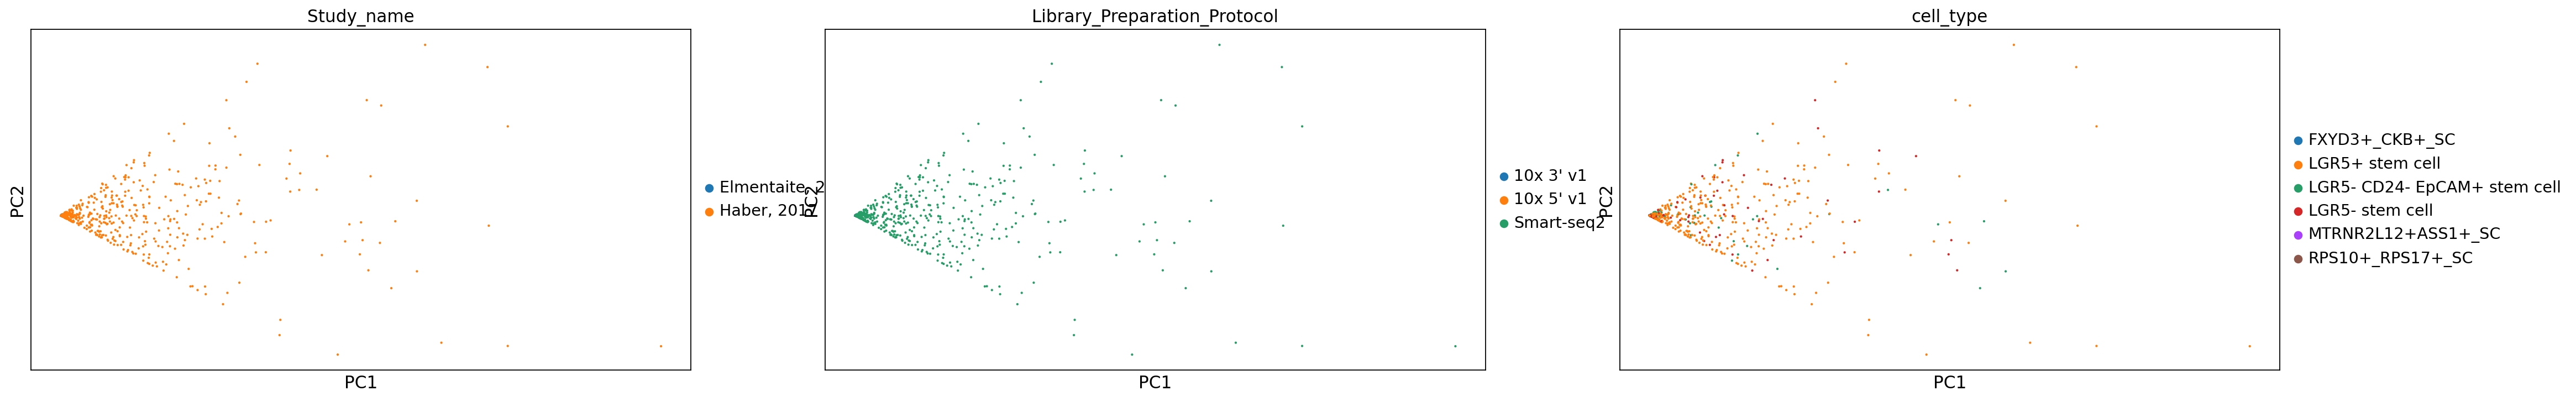

In [69]:
sc.set_figure_params(figsize=(10,5))
sc.pl.pca(adata,color=["Study_name", "Library_Preparation_Protocol", "cell_type"])

+ Extract highly variable genes

In [ ]:
adata.layers['counts'] = adata.X.copy()

In [71]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 3000,
    layer = "counts",
    batch_key = "Library_Preparation_Protocol",
    subset = True,
    span = 1
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 8306 × 11
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'leiden', 'cluster', 'cell_type', 'barcode', 'Gene_marker', 'GFP_intensity', 'full_cell_description', 'Sample'
    var: 'feature_types-0-0-0-human', 'gene_name-1-0-0-human', 'gene_id-0-0-human', 'GENE-1-0-human', 'n_counts-human', 'n_cells-human', 'n_counts-mouse', 'n_cells-mouse', 'ensemble_gene_id_version-mouse', 'ensemble_gene_id-mouse', 'start_position-mouse', 'end_position-mouse', 'chromosome_name-mouse', 'external_gene_name-mouse', 'Gene stable ID-mouse', 'Gene stable ID version-mouse', 'Transcrip

#### Run scVI

In [72]:
scvi.model.SCVI.setup_anndata(adata, 
                              categorical_covariate_keys=['Library_Preparation_Protocol'],
                                continuous_covariate_keys=['n_counts', 'n_genes'],
                              labels_key = "cell_type", 
                              layer = 'counts')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [73]:
scvi_model = scvi.model.SCVI(adata,
                            n_latent = 50, 
                            n_layers = 3, 
                            dispersion = 'gene-batch', 
                            gene_likelihood = 'nb')

In [74]:
scvi_model.train(30, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = "gpu",
                 devices = [0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30/30: 100%|████████████████████| 30/30 [00:11<00:00,  2.86it/s, v_num=1, train_loss_step=3.22, train_loss_epoch=4.02]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|████████████████████| 30/30 [00:11<00:00,  2.61it/s, v_num=1, train_loss_step=3.22, train_loss_epoch=4.02]


In [75]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

#### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

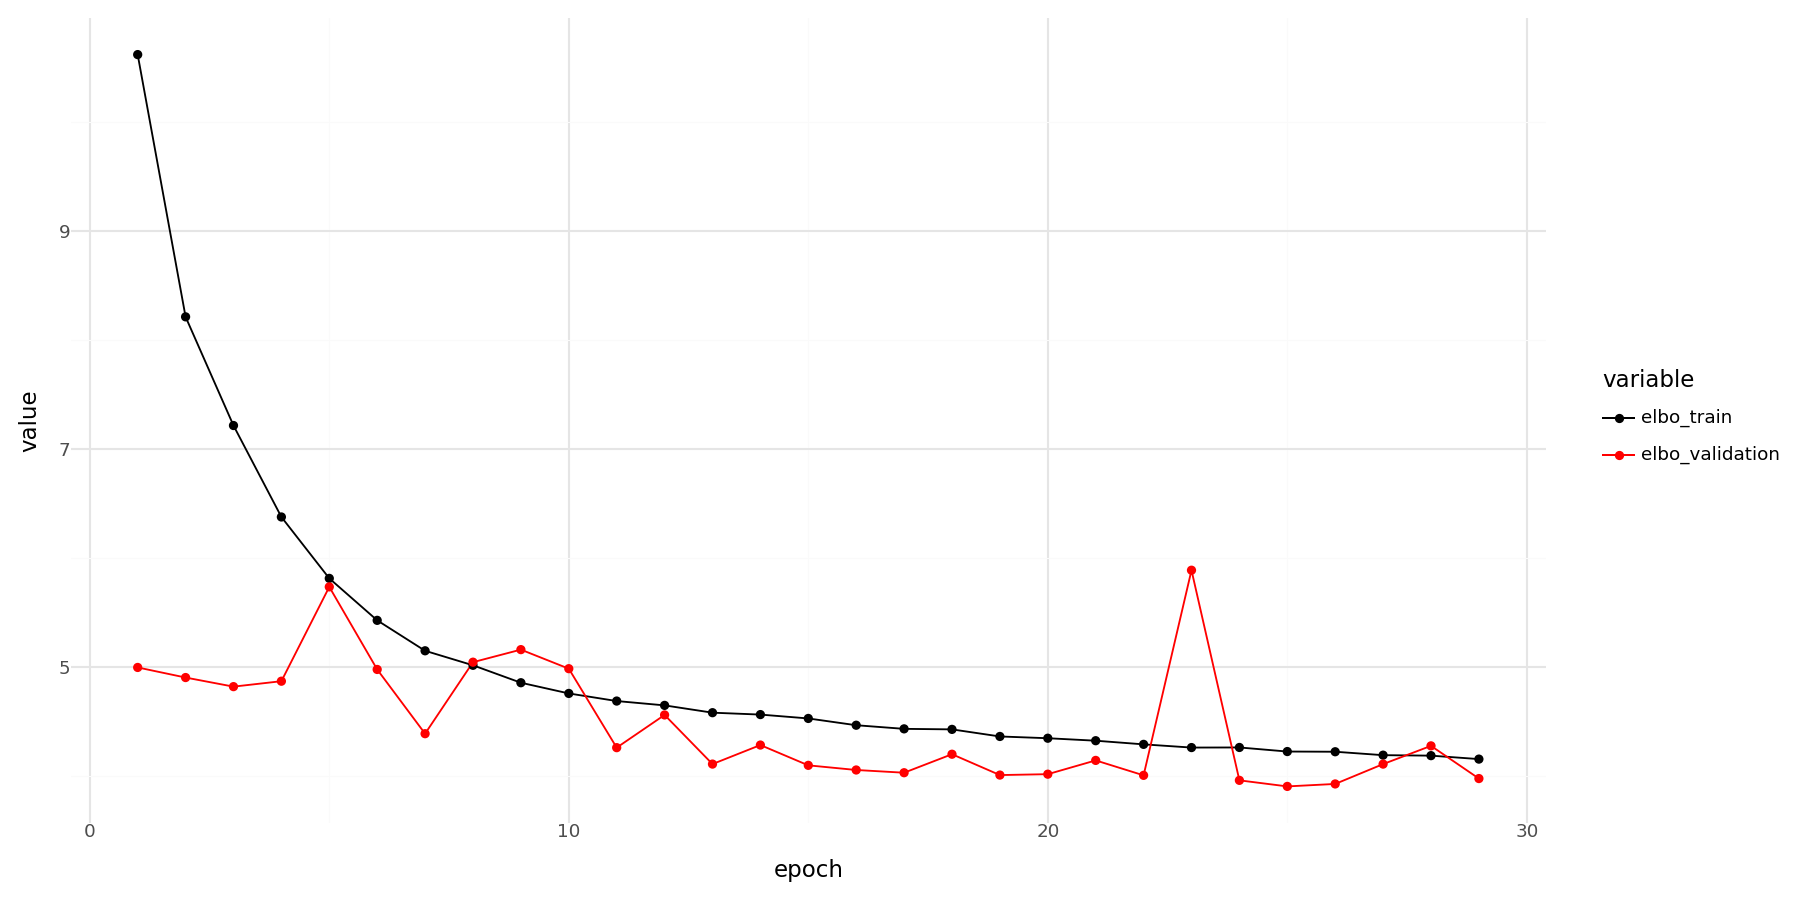

In [76]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

#### Label transfer with `scANVI` 

In [77]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [78]:
scanvi_model.train(100, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [0])

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 100/100: 100%|████████████████| 100/100 [01:38<00:00,  1.07it/s, v_num=1, train_loss_step=37.6, train_loss_epoch=33.6]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|████████████████| 100/100 [01:38<00:00,  1.02it/s, v_num=1, train_loss_step=37.6, train_loss_epoch=33.6]


In [79]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [80]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

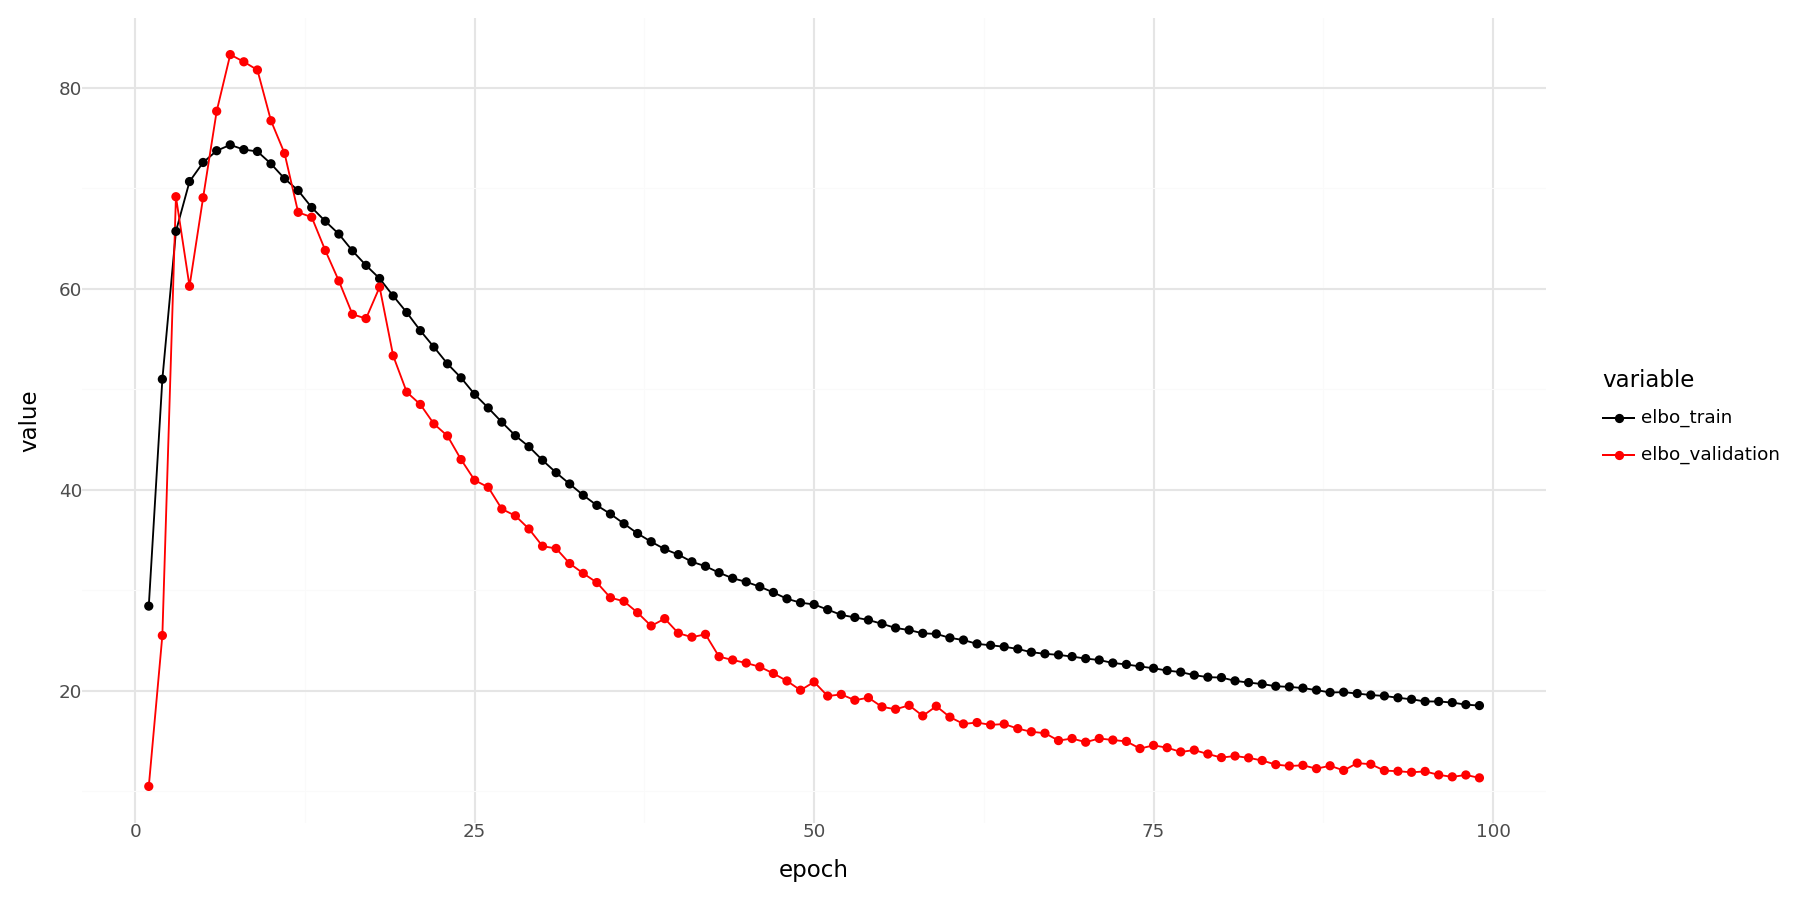

In [81]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

+ Visualize dataset

In [82]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:47)


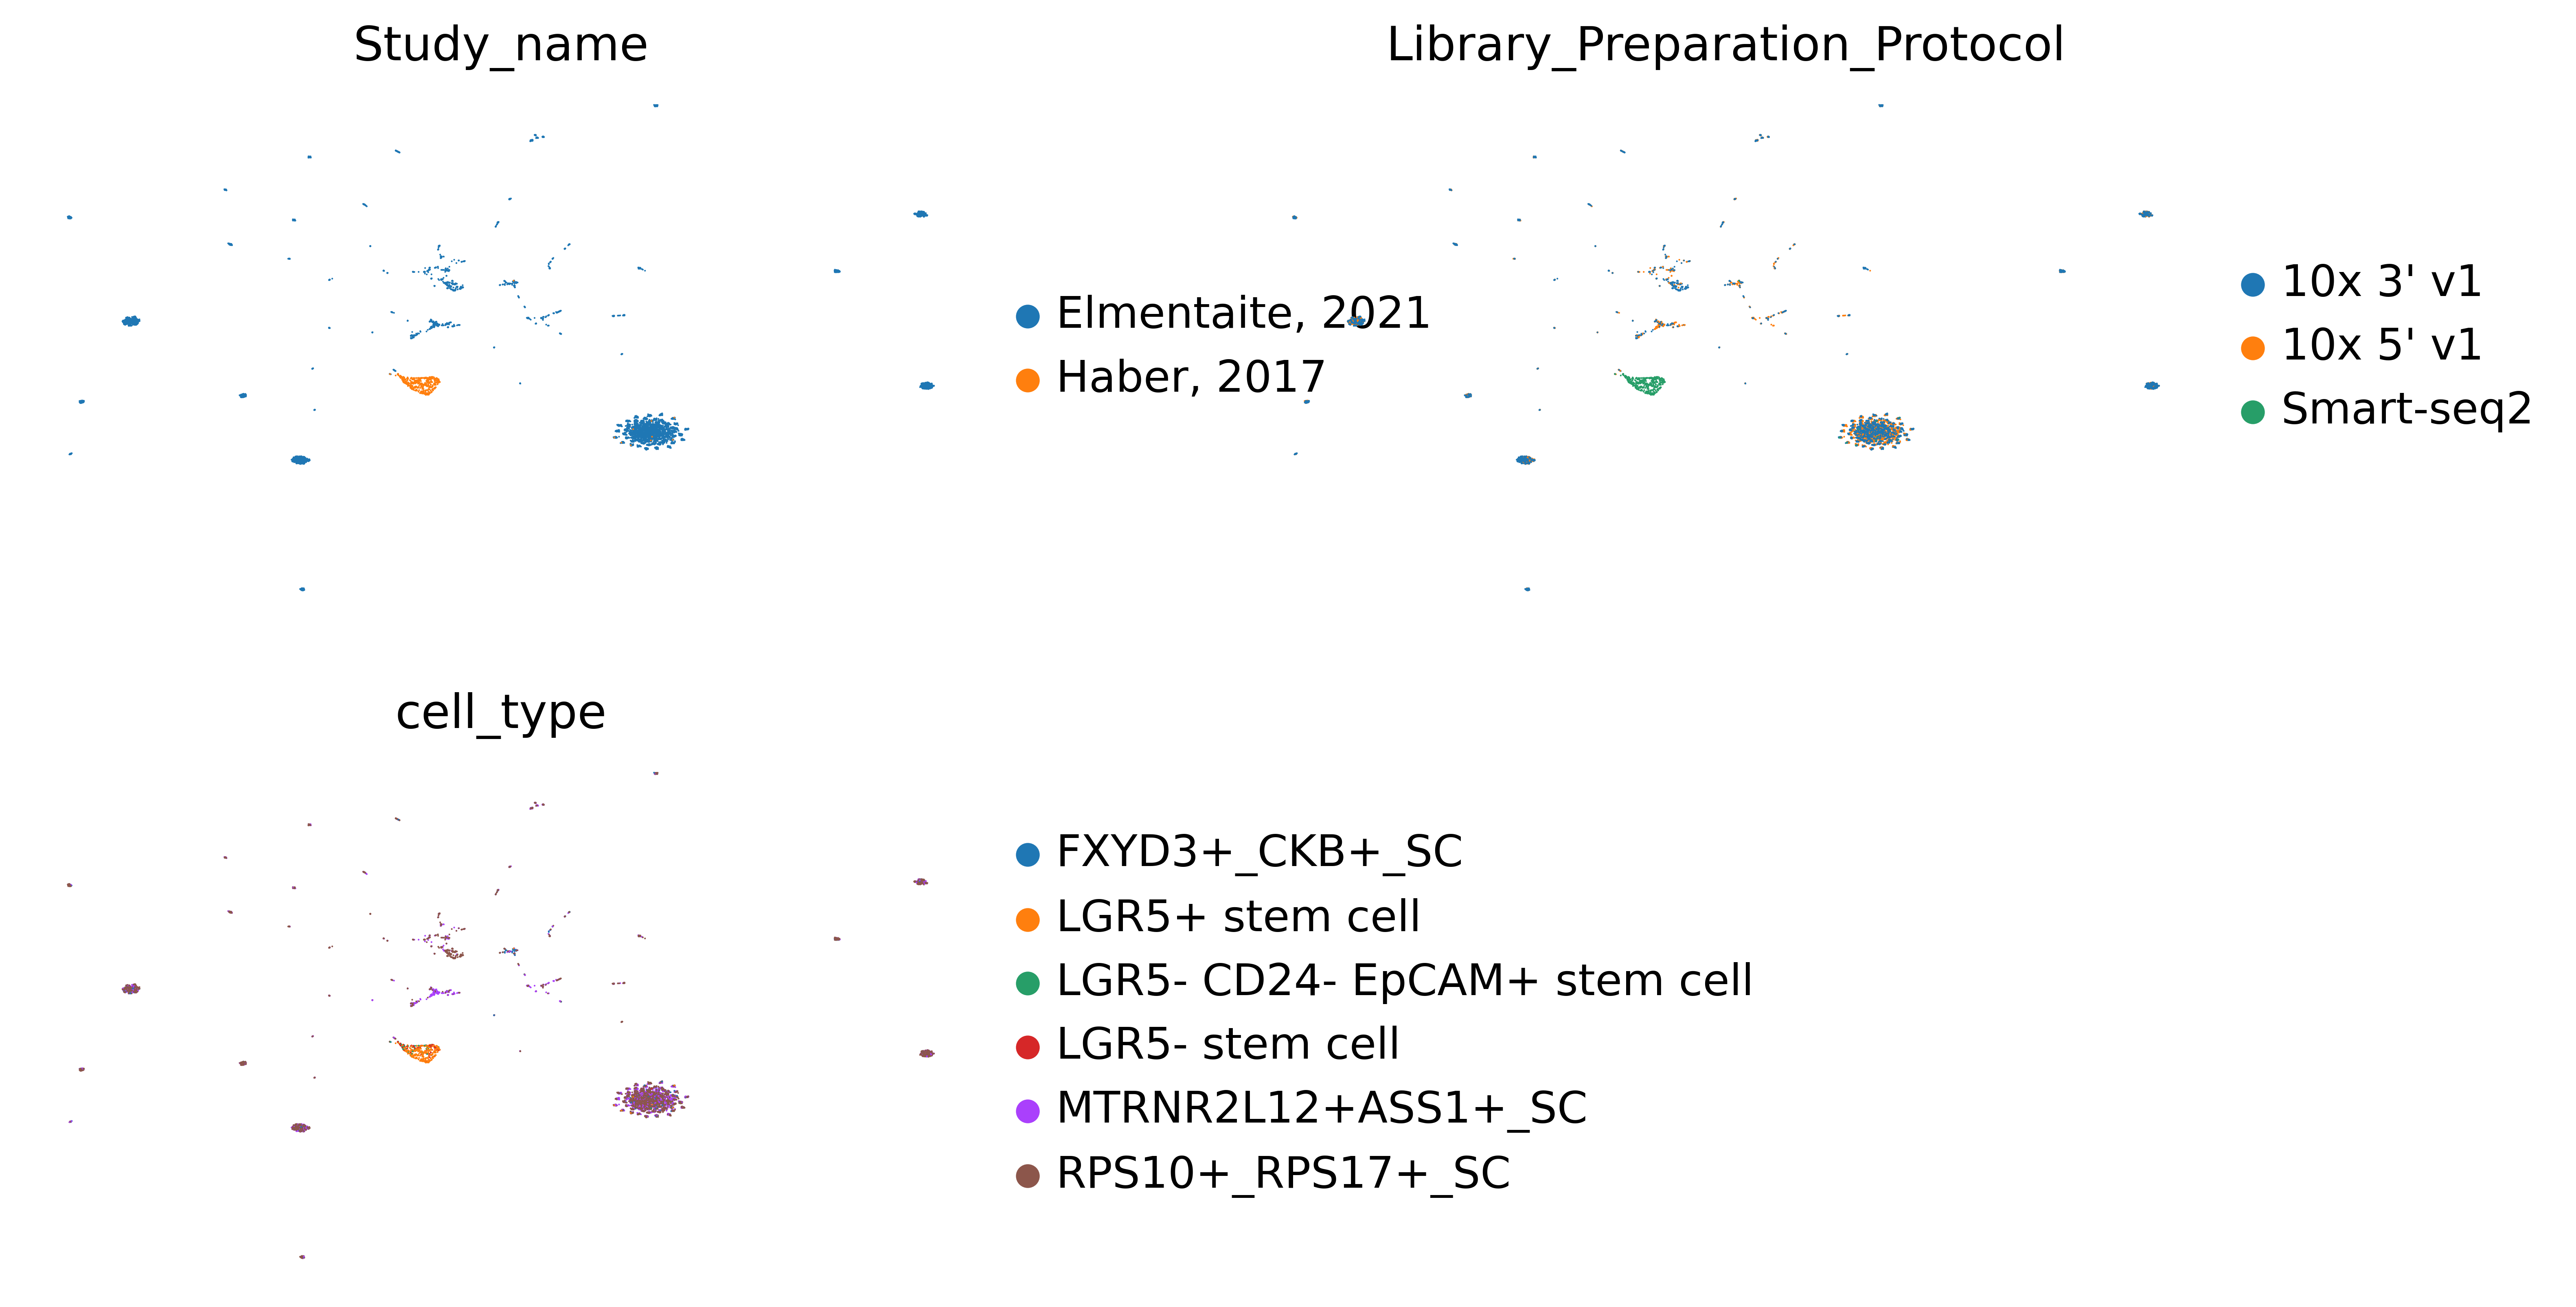

In [83]:
sc.set_figure_params(dpi = 300, figsize=(5,3))
sc.pl.umap(adata, color = ["Study_name", "Library_Preparation_Protocol", "cell_type"], ncols = 2, frameon = False, size = 1)

+ Check scIB metrics

In [84]:
SATRUN_adata = sc.read_h5ad("data/saturn_results/test256_data_FetalSC_for_SATURN_Haber_2017_Smartseq_stem_cells_remapped_org_saturn_seed_0.h5ad")

In [85]:
SATRUN_adata

AnnData object with n_obs × n_vars = 8306 × 256
    obs: 'labels', 'labels2', 'ref_labels', 'species'
    uns: 'labels2_colors', 'neighbors', 'pca', 'species_colors', 'umap'
    obsm: 'X_pca', 'X_saturn', 'X_umap', 'macrogenes'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [86]:
adata.obsm['X_saturn'] = SATRUN_adata.obsm['X_saturn'].copy()

In [87]:
adata

AnnData object with n_obs × n_vars = 8306 × 11
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'leiden', 'cluster', 'cell_type', 'barcode', 'Gene_marker', 'GFP_intensity', 'full_cell_description', 'Sample', 'C_scANVI'
    var: 'feature_types-0-0-0-human', 'gene_name-1-0-0-human', 'gene_id-0-0-human', 'GENE-1-0-human', 'n_counts-human', 'n_cells-human', 'n_counts-mouse', 'n_cells-mouse', 'ensemble_gene_id_version-mouse', 'ensemble_gene_id-mouse', 'start_position-mouse', 'end_position-mouse', 'chromosome_name-mouse', 'external_gene_name-mouse', 'Gene stable ID-mouse', 'Gene stable ID version-mouse'

In [88]:
bm = Benchmarker(
    adata,
    batch_key='Library_Preparation_Protocol',
    label_key='cell_type',
    embedding_obsm_keys=['X_pca', 'X_scVI', 'X_scANVI', 'X_saturn'],
    n_jobs=-1
)

bm.benchmark()

computing PCA
    with n_comps=10
    finished (0:00:00)


Embeddings:   0%|                                                                                     | 0/4 [00:00<?, ?it/s]

INFO     LGR5+ stem cell consists of a single batch or is too small. Skip.                                         
INFO     LGR5- CD24- EpCAM+ stem cell consists of a single batch or is too small. Skip.                            
INFO     LGR5- stem cell consists of a single batch or is too small. Skip.                                         


Embeddings:  25%|███████████████████▎                                                         | 1/4 [00:07<00:23,  7.95s/it]

INFO     LGR5+ stem cell consists of a single batch or is too small. Skip.                                         
INFO     LGR5- CD24- EpCAM+ stem cell consists of a single batch or is too small. Skip.                            
INFO     LGR5- stem cell consists of a single batch or is too small. Skip.                                         


Embeddings:  50%|██████████████████████████████████████▌                                      | 2/4 [00:19<00:19,  9.83s/it]

INFO     LGR5+ stem cell consists of a single batch or is too small. Skip.                                         
INFO     LGR5- CD24- EpCAM+ stem cell consists of a single batch or is too small. Skip.                            
INFO     LGR5- stem cell consists of a single batch or is too small. Skip.                                         


Embeddings:  75%|█████████████████████████████████████████████████████████▊                   | 3/4 [00:29<00:10, 10.20s/it]

INFO     LGR5+ stem cell consists of a single batch or is too small. Skip.                                         
INFO     LGR5- CD24- EpCAM+ stem cell consists of a single batch or is too small. Skip.                            
INFO     LGR5- stem cell consists of a single batch or is too small. Skip.                                         


Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.63s/it]


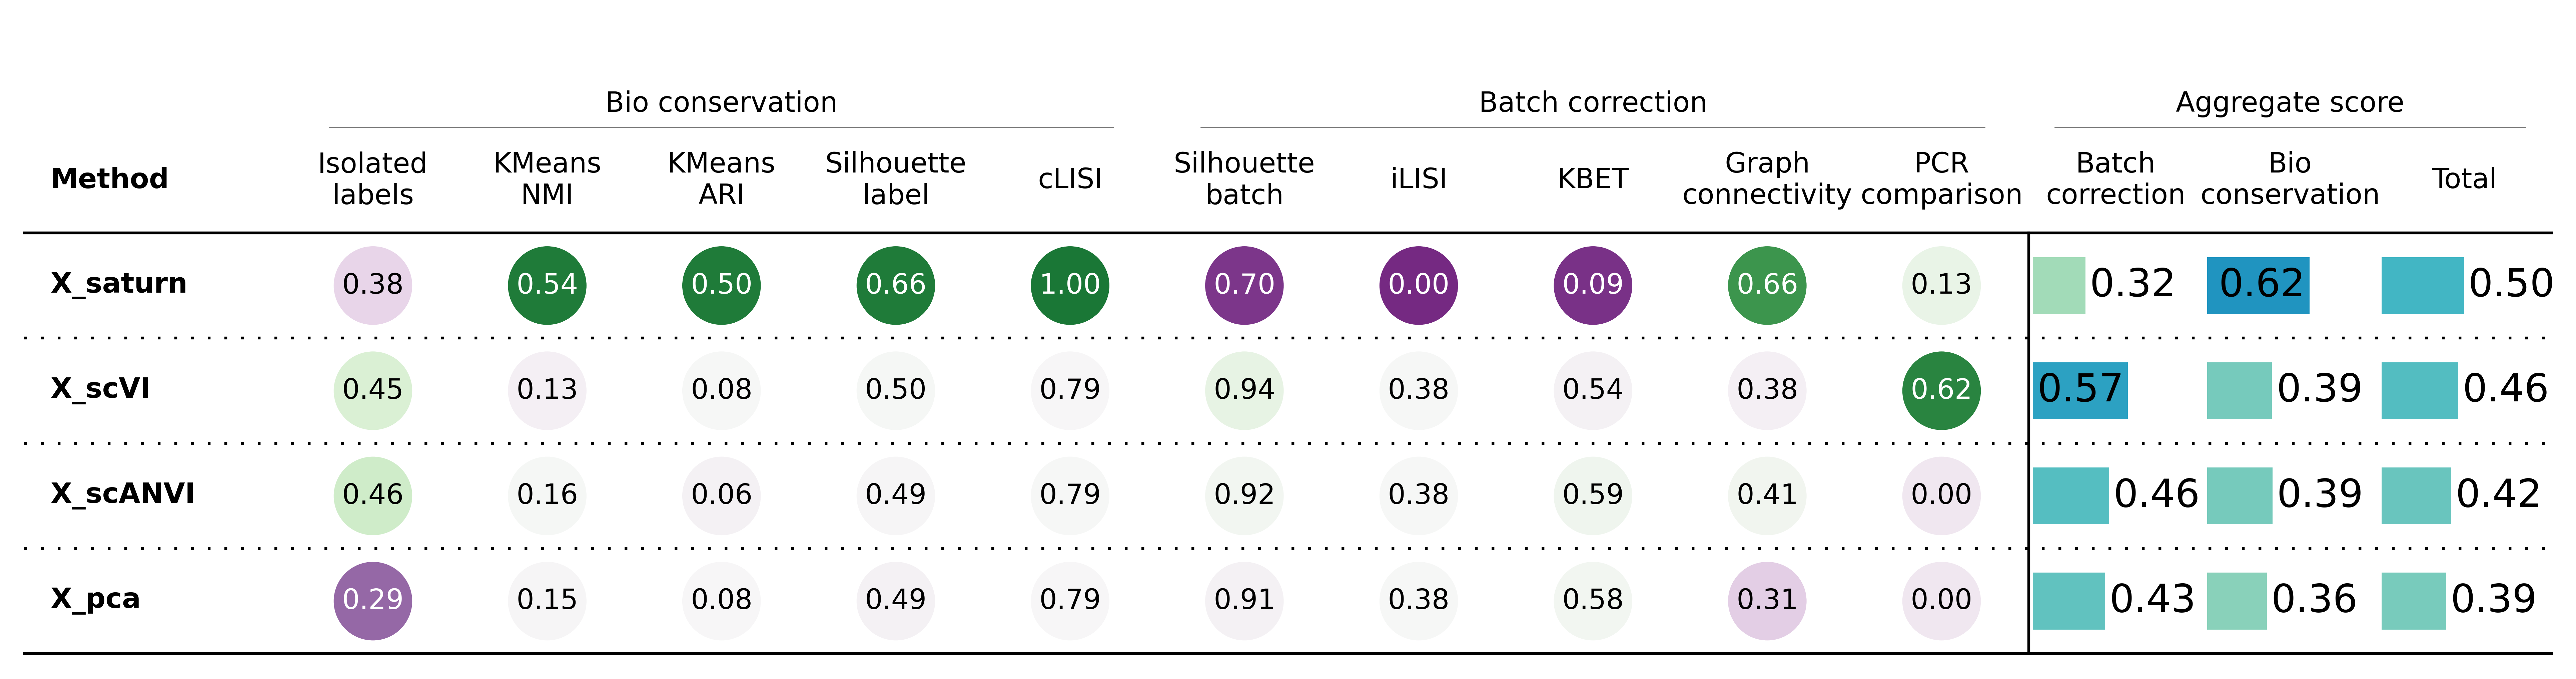

In [89]:
bm.plot_results_table(min_max_scale=False)

In [90]:
bm = Benchmarker(
    adata,
    batch_key='n_counts',
    label_key='cell_type',
    embedding_obsm_keys=['X_pca', 'X_scVI', 'X_scANVI', 'X_saturn'],
    n_jobs=-1
)

bm.benchmark()

computing PCA
    with n_comps=10
    finished (0:00:00)


Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [03:19<00:00, 49.76s/it]


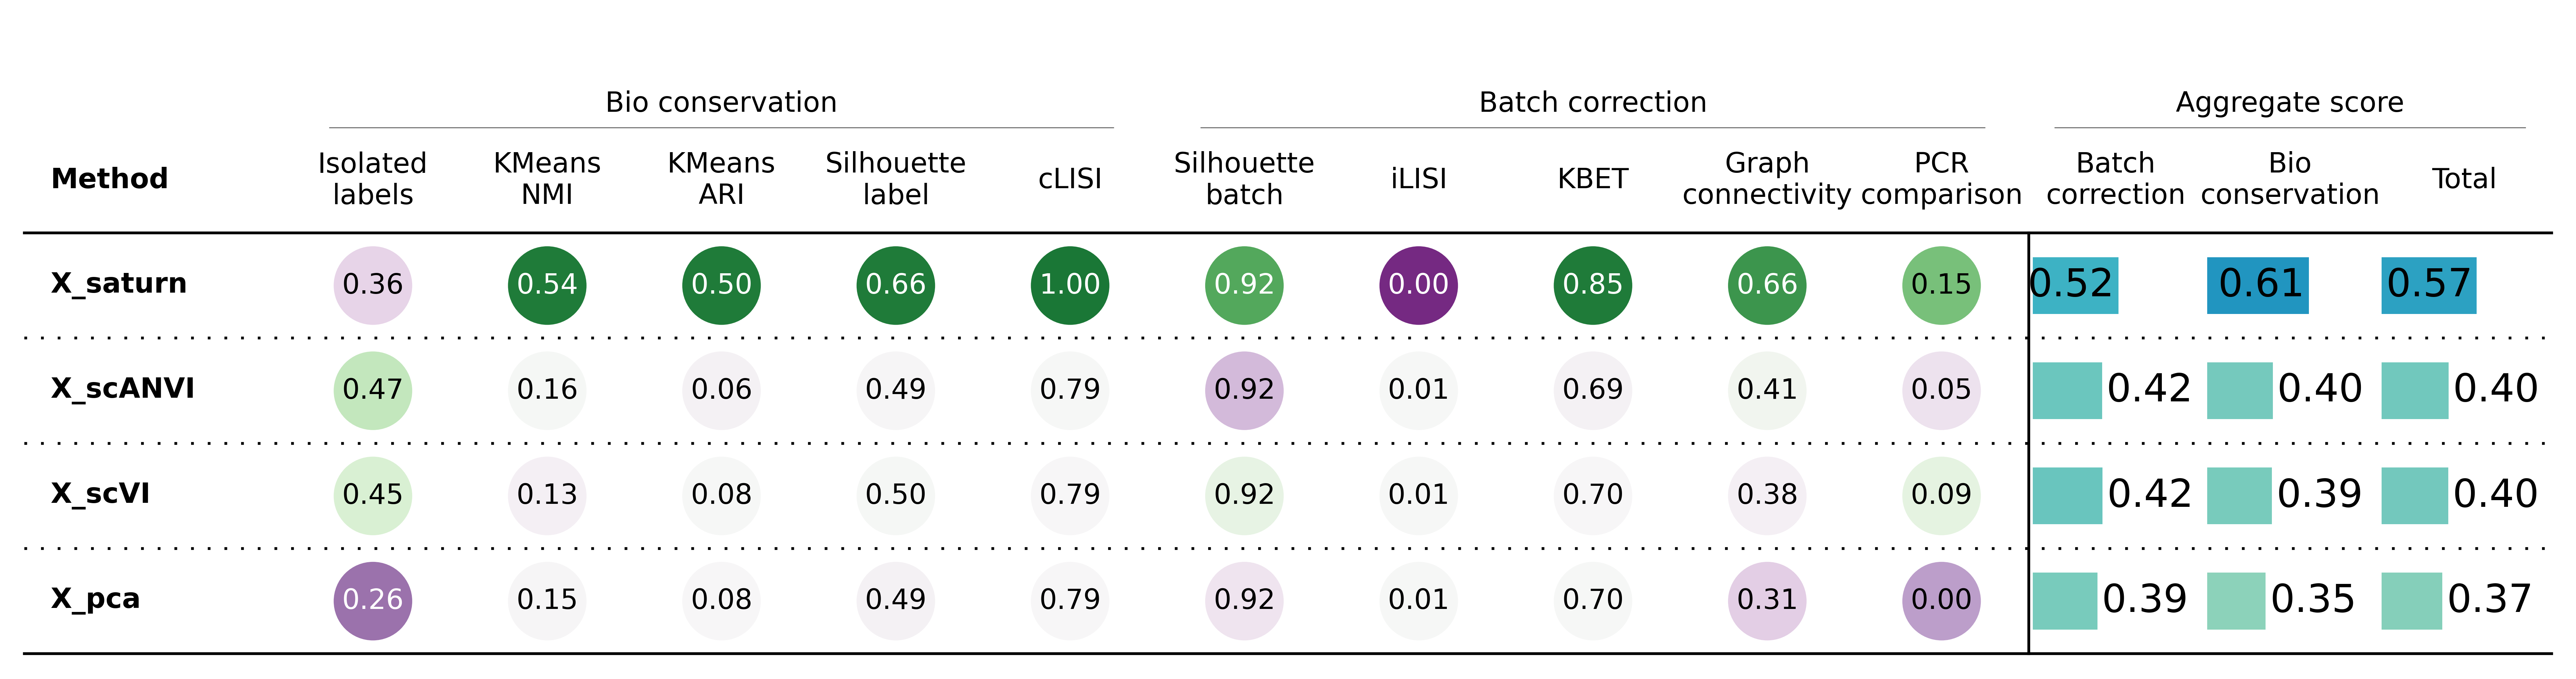

In [91]:
bm.plot_results_table(min_max_scale=False)

computing PCA
    with n_comps=10
    finished (0:00:00)


Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [01:38<00:00, 24.75s/it]


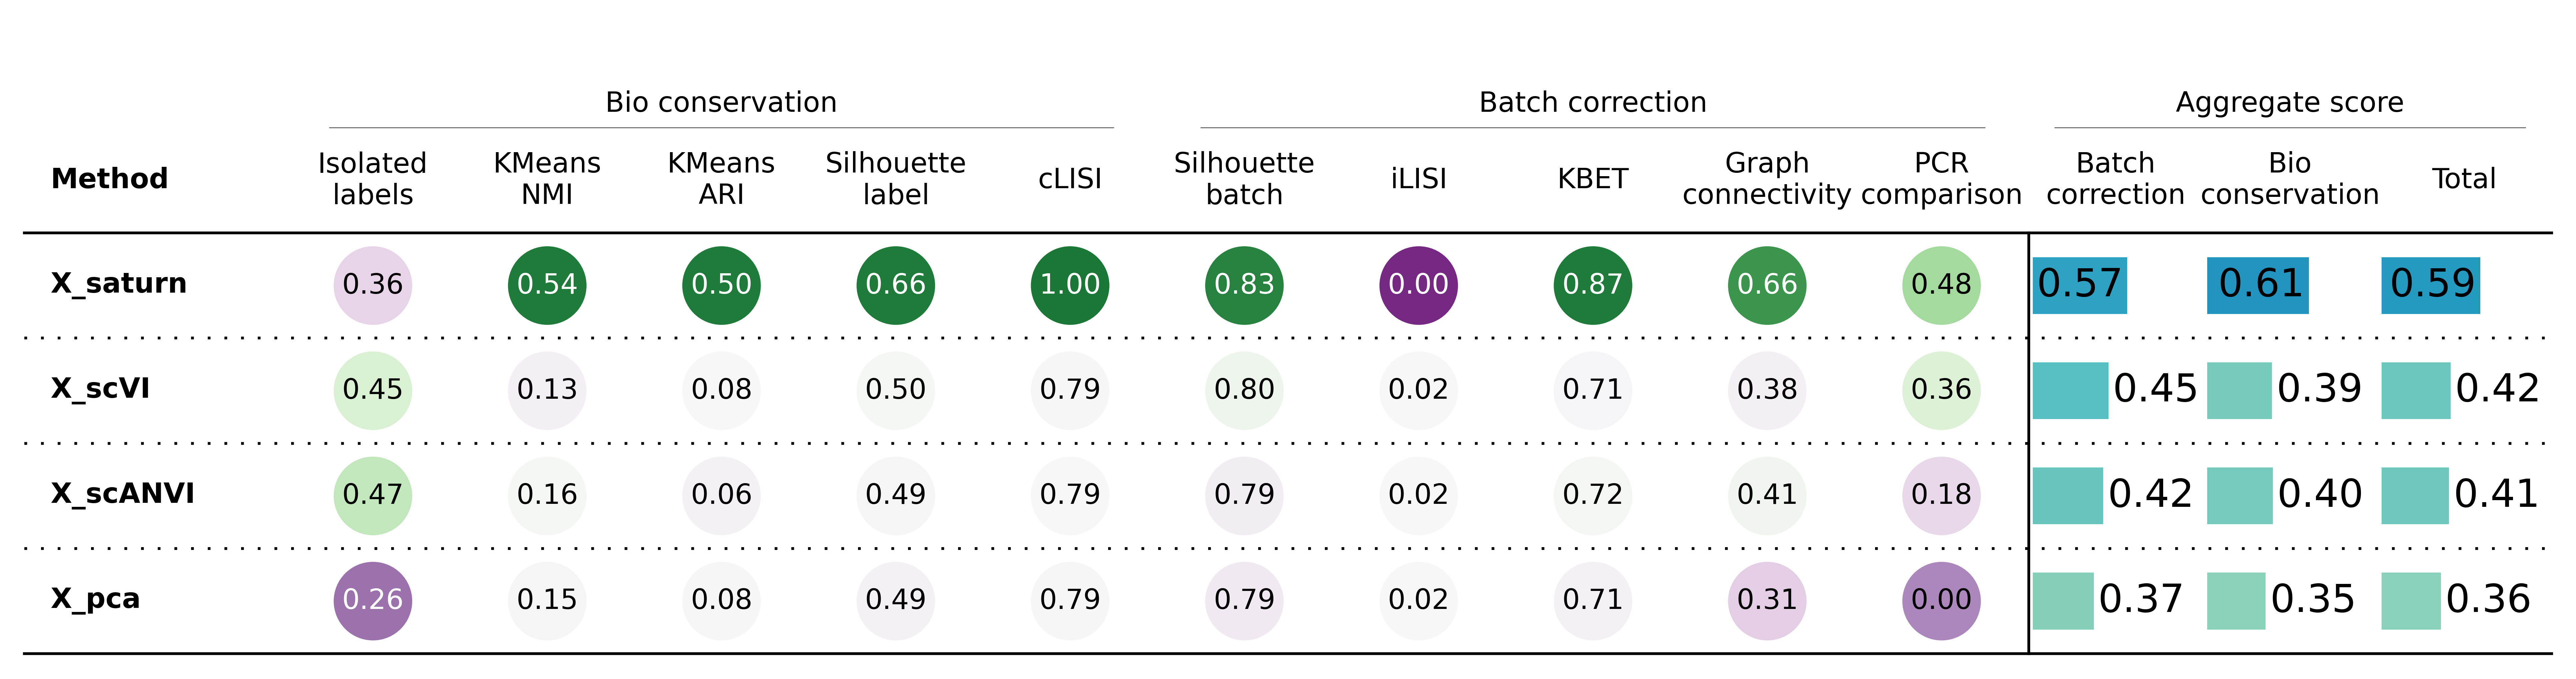

In [92]:
bm = Benchmarker(
    adata,
    batch_key='n_genes',
    label_key='cell_type',
    embedding_obsm_keys=['X_pca', 'X_scVI', 'X_scANVI', 'X_saturn'],
    n_jobs=-1
)

bm.benchmark()

bm.plot_results_table(min_max_scale=False)